In [1]:
! nvidia-smi

Thu Jul 30 18:21:09 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    12W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import warnings
warnings.filterwarnings('ignore')
import zipfile
from zipfile import ZipFile
from pathlib import Path
from time import time
from datetime import datetime 
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from PIL import Image
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import cv2
import pkgutil
import importlib
import os
import random
%matplotlib inline
%config IPCompleter.greedy=True
%reload_ext autoreload
import io
import skimage
from skimage.transform import resize
from itertools import groupby
from tqdm.auto import tqdm
import gc
import seaborn as sns
sns.set()
print('Pytorch version:', torch.__version__)

Pytorch version: 1.5.1+cu101


In [4]:
%%time
from zipfile import ZipFile
with ZipFile('/content/gdrive/My Drive/ThumbnailData.zip', mode='r') as input:
  input.extractall('.')

CPU times: user 1.39 s, sys: 913 ms, total: 2.3 s
Wall time: 3.58 s


In [5]:
def prepare_data(root, classes):
  finaldata = []
  for i in range(len(classes)):
    path = root + '/' + classes[i] + '/'
    data_rec = [(path+file_name, i) for file_name in os.listdir(path)]
    finaldata.extend(data_rec) 
  random.shuffle(finaldata)
  return finaldata

In [6]:
class_list       = [0,1,2,3]
class_names_dict = {0:'FB', 1:'LQ', 2:'SQ', 3:'WD'}
class_names      = ['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']

In [7]:
dataset          = prepare_data('/content/Data',class_names)
print(f'Dataset Length:{len(dataset)}, Train Data length: {int(len(dataset)*0.7)},Test Data length: {int(len(dataset)*0.3)}')
train_len = int(len(dataset)*0.7)

Dataset Length:19318, Train Data length: 13522,Test Data length: 5795


In [8]:
# Copying the code from github to colab
os.chdir('/content/')
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA4_Phase2

Cloning into 'Deep_Learning_EVA4_Phase2'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 331 (delta 41), reused 0 (delta 0), pack-reused 234
Receiving objects: 100% (331/331), 2.55 MiB | 7.12 MiB/s, done.
Resolving deltas: 100% (165/165), done.


In [9]:
%cd '/content/Deep_Learning_EVA4_Phase2/S2_Mobilenet_QuadCopters_Lambda'
! ls

/content/Deep_Learning_EVA4_Phase2/S2_Mobilenet_QuadCopters_Lambda
EVA4P2_S2_MobilenetV2_V1.ipynb	EVA4P2_S2_MobilenetV2_V2.ipynb	README.md  src


In [10]:
os.chdir('/content/Deep_Learning_EVA4_Phase2/S2_Mobilenet_QuadCopters_Lambda/')
import src
from src.dataset import datatransforms as dtf
from src.dataset import customdataset as cds
from src.dataset import Alb_data_transforms as Alb
from src.models  import S15_FGDepth_models as ntwk
from src.losses  import Train_Losses
from src.losses  import Test_Losses
from src.utils   import Freeze_Layers as Freeze

In [11]:
import albumentations as A
channel_means  = (0.48043839, 0.44820218, 0.39760034)
channel_stdevs = (0.27698959, 0.26908774, 0.28216029)
# Train Phase transformations
train_transforms = Alb.Albumentations_transform([
                                      A.Rotate((-30.0, 30.0)),
                                      A.HorizontalFlip(),
                                      A.Resize(224, 224),
                                      A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                      A.Normalize(mean=channel_means, std=channel_stdevs),
                                      A.Cutout(num_holes=1, max_h_size=56, max_w_size=56), # fillvalue is 0 after normalizing as mean is 0
                                    ])

fillmeans = (np.array(channel_means)).astype(np.uint8)

# Test Phase transformations
test_transforms = Alb.Albumentations_transform([A.Resize(224, 224),
                                                A.Normalize(mean=channel_means, std=channel_stdevs),])

In [12]:
train = cds.Customdataset(dataset[:train_len],train_transforms)
test  = cds.Customdataset(dataset[train_len:],test_transforms)
print(f'Train Length {len(train)}, Test Length {len(test)}')

Train Length 13522, Test Length 5796


In [13]:
train_loader  = DataLoader(train, batch_size = 32,shuffle = True, pin_memory = True)
test_loader   = DataLoader(test, batch_size = 32, shuffle = True, pin_memory = True)

In [14]:
def unnormalize(img):
  img = img.cpu().numpy().astype(dtype=np.float32)
  #print(img.shape)
  for i in range(img.shape[0]):
    img[i] = (img[i]*channel_stdevs[i]) + channel_means[i]
  return np.transpose(img, (1,2,0))

In [15]:
dataiter = iter(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


To check if images are coming out correctly as batches, images.shape: torch.Size([32, 3, 224, 224]), labels.shape: torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


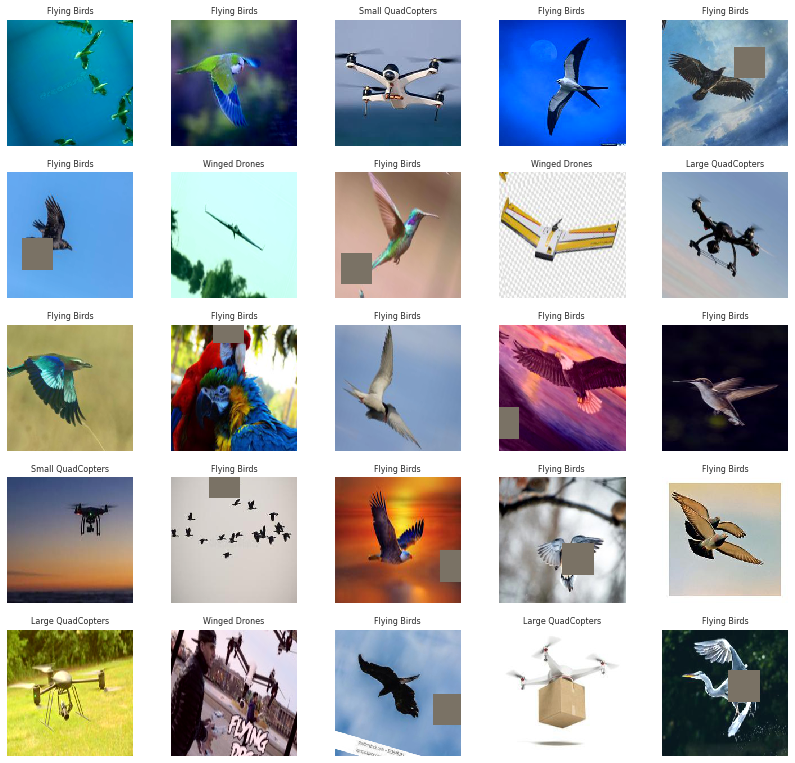

In [16]:
images, labels = dataiter.next()
print(f'To check if images are coming out correctly as batches, images.shape: {images.shape}, labels.shape: {labels.shape}')
num_classes = len(class_names)
r, c = 5, 5
fig = plt.figure(figsize=(14,14))
fig.subplots_adjust(hspace=0.01, wspace=0.3)
for i in range(r):
  for j in range(c):
    idx = i*c + j
    ax  = plt.subplot(r,c, idx + 1)
    ax.set_title(class_names[labels[idx]][:30], fontdict={'fontsize':8})
    plt.axis('off')
    ax.imshow(unnormalize(images[idx]), interpolation ='none')
plt.show()    

### Downloading Pretrained Mobilenet_V2 and displaying summary to understand the layers & corresponding parms

In [17]:
!pip install torchsummary
from torchsummary import summary
model = torch.hub.load('pytorch/vision:v0.6.0','mobilenet_v2',pretrained=True)
use_cuda = torch.cuda.is_available()
model.device = torch.device("cuda" if use_cuda else "cpu")
model.to(model.device)
summary(model, input_size=(3, 224, 224))

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96

### Unfreezing only selected layers. Also customizing the FC layer to predict only 4 classes instead of 1000 classes (Mobilenet V2 is pretrained against imagenet which has 1000 classes)

In [18]:
for param in model.parameters():
    param.requires_grad = False

model.classifier[1] = torch.nn.Linear(in_features=model.classifier[1].in_features, out_features=4).to("cuda")
model.features[16].requires_grad  = True
model.features[17].requires_grad  = True
model.features[18].requires_grad  = True
model.classifier[0].requires_grad = True
model.classifier[1].requires_grad = True

### Displaying Layerwise view to understand convolutions, BN, Relu etc. coming under each layer. Will help us to reach a decision in which layer to unfreeze

In [19]:
model.to(model.device)

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [20]:
train_loss = Train_Losses.Train_loss()
test_loss  = Test_Losses.Test_loss()

### Displaying layer names against model. Will help us to customize/ unfreeze/ freeze selected layers

In [21]:
for name, module in model.named_modules():
    print('name:',name)

name: 
name: features
name: features.0
name: features.0.0
name: features.0.1
name: features.0.2
name: features.1
name: features.1.conv
name: features.1.conv.0
name: features.1.conv.0.0
name: features.1.conv.0.1
name: features.1.conv.0.2
name: features.1.conv.1
name: features.1.conv.2
name: features.2
name: features.2.conv
name: features.2.conv.0
name: features.2.conv.0.0
name: features.2.conv.0.1
name: features.2.conv.0.2
name: features.2.conv.1
name: features.2.conv.1.0
name: features.2.conv.1.1
name: features.2.conv.1.2
name: features.2.conv.2
name: features.2.conv.3
name: features.3
name: features.3.conv
name: features.3.conv.0
name: features.3.conv.0.0
name: features.3.conv.0.1
name: features.3.conv.0.2
name: features.3.conv.1
name: features.3.conv.1.0
name: features.3.conv.1.1
name: features.3.conv.1.2
name: features.3.conv.2
name: features.3.conv.3
name: features.4
name: features.4.conv
name: features.4.conv.0
name: features.4.conv.0.0
name: features.4.conv.0.1
name: features.4.c

#### Function to calculate class-wise accuracy

In [22]:
def calc_classwiseacc(total_cnt,correct_cnt):
    class_test_acc = []
    epsilon    = 1e-10                     # To avoid division by zero incase not a single image showed up for a particular class
    for i in range(len(class_list)):
        correct_class   =  total_class = 0
        correct_class   =  correct_cnt.get(class_list[i])
        total_class     =  total_cnt.get(class_list[i])
        total_class     += epsilon
        class_accuracy  =  round((correct_class/total_class *100), 2)
        class_test_acc.append(class_accuracy)
        print ('Test accuracy for class - ', class_list[i], ' - ', class_names_dict.get(class_list[i]), ' : ', class_accuracy, \
               'correct:',correct_class, 'Total:',int(total_class) )
    
    print('Total Test Images:',sum(total_cnt.values()),'Correct Images:',sum(correct_cnt.values()) )

    return class_test_acc

#### Command to load the model from saved model weights from previous training.

In [42]:
#path = f'/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_0730V1.pt'
#model.load_state_dict(torch.load(path))

#### Train & Test for fixed epochs

In [23]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import OneCycleLR

EPOCH         = 50
L2_factor     = 0.0001
L1_factor     = 0.0005
least_loss_lr = 0.03

train_loss_all = []
train_acc_all  = []
test_loss_all  = []
test_acc_all   = []
classwise_acc  = []
class_acc_all  = []
prev_lr_value  = least_loss_lr

OPTIMIZER = optim.SGD(model.parameters(),lr=least_loss_lr, momentum=0.9, weight_decay=L2_factor)
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode='min',factor=0.1, min_lr=1e-10, patience =4, verbose=True)
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCH):
  print('\nEPOCH:', epoch)
  train_losses, train_acc, lr_value = train_loss.train_loss_calc(model,model.device,train_loader=train_loader,optimizer=OPTIMIZER,
                                                       epoch=EPOCH, factor=L1_factor,criterion=criterion,
                                                       scheduler=SCHEDULER,print_idx=0,maxlr=0.2)
  test_losses, test_acc, wrong_predict, predicted_class, actual_class, label_total, label_correct, correct_predict, correct_pred_class, correct_act_class = \
                            test_loss.test_loss_calc(model,model.device,test_loader=test_loader,optimizer=OPTIMIZER,
                                                     total_epoch=EPOCH,current_epoch=epoch,criterion=criterion,
                                                     scheduler=SCHEDULER) 
  train_loss_all.extend(train_losses)
  train_acc_all.extend(train_acc)
  test_loss_all.extend(test_losses)
  test_acc_all.extend(test_acc)
  
  loss_decrease = 0  
  if len(test_loss_all) > 1:    
    loss_decrease = test_loss_all[-2] - test_loss_all[-1]
    if loss_decrease > 0:
      print(f'Test Loss -> Decreasing, Prev Loss:{test_loss_all[-2]:.6f}, Latest Loss:{test_loss_all[-1]:.6f}, Delta:{loss_decrease:.6f}')
    else:
      print(f'Test Loss -> Increasing, Prev Loss:{test_loss_all[-2]:.6f}, Latest Loss:{test_loss_all[-1]:.6f}, Delta:{loss_decrease:.6f}')

  if lr_value < prev_lr_value:           ### Save the model values if loss values stabilized significantly 
    print(f' **** Model Stable, hence Saved in epoch:{epoch} Prev Lr:{prev_lr_value} New Lr:{lr_value}')
    path_model_save = f'/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Stable_0730V3.pt'
    torch.save(model.state_dict(),path_model_save) 
  
  prev_lr_value = lr_value

  if epoch == (EPOCH - 1):              ### Save the model values on final epoch
    print(f' **** Model Saved in Final epoch:{epoch} Lr Value:{lr_value}')
    path_model_save = f'/content/gdrive/My Drive/EVA4P2_S2_Weights/Mobilenet_V2_Final_0730V3.pt'
    torch.save(model.state_dict(),path_model_save)

    classwise_acc = calc_classwiseacc(label_total,label_correct)
    class_acc_all.append(classwise_acc)  


  0%|          | 0/423 [00:00<?, ?it/s]


EPOCH: 0


Train Loss = 2.1499855518341064 Batch Id = 422 Train Acc = 69.55 LR =0.030000: 100%|██████████| 423/423 [00:57<00:00,  7.32it/s]
Train Loss = 2.764678716659546 Batch Id = 0 Train Acc = 59.38 LR =0.030000:   0%|          | 1/423 [00:00<00:59,  7.14it/s]


Test set: Average loss: 0.0511, Test Accuracy: 73.86, LR : 0.030000

EPOCH: 1


Train Loss = 0.7034424543380737 Batch Id = 422 Train Acc = 71.42 LR =0.030000: 100%|██████████| 423/423 [00:56<00:00,  7.43it/s]
Train Loss = 2.251060724258423 Batch Id = 0 Train Acc = 75.00 LR =0.030000:   0%|          | 1/423 [00:00<00:59,  7.08it/s]


Test set: Average loss: 0.0423, Test Accuracy: 78.59, LR : 0.030000
Test Loss -> Decreasing, Prev Loss:0.051060, Latest Loss:0.042319, Delta:0.008741

EPOCH: 2


Train Loss = 1.3558804988861084 Batch Id = 422 Train Acc = 71.45 LR =0.030000: 100%|██████████| 423/423 [00:56<00:00,  7.47it/s]
Train Loss = 0.6792187094688416 Batch Id = 0 Train Acc = 90.62 LR =0.030000:   0%|          | 1/423 [00:00<00:58,  7.20it/s]


Test set: Average loss: 0.0393, Test Accuracy: 78.12, LR : 0.030000
Test Loss -> Decreasing, Prev Loss:0.042319, Latest Loss:0.039261, Delta:0.003058

EPOCH: 3


Train Loss = 3.561389684677124 Batch Id = 422 Train Acc = 71.54 LR =0.030000: 100%|██████████| 423/423 [00:56<00:00,  7.48it/s]
Train Loss = 1.9130865335464478 Batch Id = 0 Train Acc = 78.12 LR =0.030000:   0%|          | 1/423 [00:00<00:58,  7.15it/s]


Test set: Average loss: 0.0616, Test Accuracy: 72.88, LR : 0.030000
Test Loss -> Increasing, Prev Loss:0.039261, Latest Loss:0.061646, Delta:-0.022386

EPOCH: 4


Train Loss = 3.35764479637146 Batch Id = 422 Train Acc = 71.27 LR =0.030000: 100%|██████████| 423/423 [00:56<00:00,  7.50it/s]
Train Loss = 1.1848703622817993 Batch Id = 0 Train Acc = 78.12 LR =0.030000:   0%|          | 1/423 [00:00<00:55,  7.58it/s]


Test set: Average loss: 0.0340, Test Accuracy: 79.52, LR : 0.030000
Test Loss -> Decreasing, Prev Loss:0.061646, Latest Loss:0.034016, Delta:0.027631

EPOCH: 5


Train Loss = 1.6455155611038208 Batch Id = 422 Train Acc = 71.79 LR =0.030000: 100%|██████████| 423/423 [00:56<00:00,  7.48it/s]
Train Loss = 1.7781708240509033 Batch Id = 0 Train Acc = 62.50 LR =0.030000:   0%|          | 1/423 [00:00<00:57,  7.39it/s]


Test set: Average loss: 0.0472, Test Accuracy: 75.88, LR : 0.030000
Test Loss -> Increasing, Prev Loss:0.034016, Latest Loss:0.047190, Delta:-0.013174

EPOCH: 6


Train Loss = 2.695382833480835 Batch Id = 422 Train Acc = 71.25 LR =0.030000: 100%|██████████| 423/423 [00:56<00:00,  7.49it/s]
Train Loss = 1.626969337463379 Batch Id = 0 Train Acc = 75.00 LR =0.030000:   0%|          | 1/423 [00:00<00:59,  7.13it/s]


Test set: Average loss: 0.0356, Test Accuracy: 79.73, LR : 0.030000
Test Loss -> Decreasing, Prev Loss:0.047190, Latest Loss:0.035610, Delta:0.011580

EPOCH: 7


Train Loss = 2.728038787841797 Batch Id = 422 Train Acc = 71.39 LR =0.030000: 100%|██████████| 423/423 [00:56<00:00,  7.46it/s]
Train Loss = 0.9727967381477356 Batch Id = 0 Train Acc = 71.88 LR =0.030000:   0%|          | 1/423 [00:00<00:59,  7.08it/s]


Test set: Average loss: 0.0340, Test Accuracy: 79.88, LR : 0.030000
Test Loss -> Decreasing, Prev Loss:0.035610, Latest Loss:0.033992, Delta:0.001618

EPOCH: 8


Train Loss = 2.5891685485839844 Batch Id = 422 Train Acc = 71.25 LR =0.030000: 100%|██████████| 423/423 [00:56<00:00,  7.50it/s]
Train Loss = 1.1589938402175903 Batch Id = 0 Train Acc = 78.12 LR =0.030000:   0%|          | 1/423 [00:00<00:58,  7.15it/s]


Test set: Average loss: 0.0319, Test Accuracy: 80.04, LR : 0.030000
Test Loss -> Decreasing, Prev Loss:0.033992, Latest Loss:0.031930, Delta:0.002062

EPOCH: 9


Train Loss = 1.0652666091918945 Batch Id = 422 Train Acc = 71.68 LR =0.030000: 100%|██████████| 423/423 [00:56<00:00,  7.44it/s]
Train Loss = 1.2303975820541382 Batch Id = 0 Train Acc = 75.00 LR =0.030000:   0%|          | 1/423 [00:00<00:58,  7.23it/s]


Test set: Average loss: 0.0399, Test Accuracy: 78.83, LR : 0.030000
Test Loss -> Increasing, Prev Loss:0.031930, Latest Loss:0.039920, Delta:-0.007990

EPOCH: 10


Train Loss = 2.0303993225097656 Batch Id = 422 Train Acc = 72.65 LR =0.030000: 100%|██████████| 423/423 [00:56<00:00,  7.49it/s]
Train Loss = 0.7268079519271851 Batch Id = 0 Train Acc = 78.12 LR =0.030000:   0%|          | 1/423 [00:00<00:57,  7.30it/s]


Test set: Average loss: 0.0438, Test Accuracy: 77.43, LR : 0.030000
Test Loss -> Increasing, Prev Loss:0.039920, Latest Loss:0.043807, Delta:-0.003887

EPOCH: 11


Train Loss = 2.218242645263672 Batch Id = 422 Train Acc = 72.05 LR =0.030000: 100%|██████████| 423/423 [00:56<00:00,  7.48it/s]
Train Loss = 1.5486266613006592 Batch Id = 0 Train Acc = 75.00 LR =0.030000:   0%|          | 1/423 [00:00<01:03,  6.68it/s]


Test set: Average loss: 0.0544, Test Accuracy: 75.67, LR : 0.030000
Test Loss -> Increasing, Prev Loss:0.043807, Latest Loss:0.054422, Delta:-0.010615

EPOCH: 12


Train Loss = 1.1772196292877197 Batch Id = 422 Train Acc = 71.90 LR =0.030000: 100%|██████████| 423/423 [00:56<00:00,  7.47it/s]
Train Loss = 2.229645252227783 Batch Id = 0 Train Acc = 50.00 LR =0.030000:   0%|          | 1/423 [00:00<00:57,  7.34it/s]


Test set: Average loss: 0.0331, Test Accuracy: 80.47, LR : 0.030000
Test Loss -> Decreasing, Prev Loss:0.054422, Latest Loss:0.033081, Delta:0.021341

EPOCH: 13


Train Loss = 0.8549332022666931 Batch Id = 422 Train Acc = 71.00 LR =0.030000: 100%|██████████| 423/423 [00:56<00:00,  7.55it/s]
Train Loss = 2.542750597000122 Batch Id = 0 Train Acc = 62.50 LR =0.003000:   0%|          | 1/423 [00:00<00:55,  7.54it/s]

Epoch    14: reducing learning rate of group 0 to 3.0000e-03.

Test set: Average loss: 0.0451, Test Accuracy: 77.07, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.033081, Latest Loss:0.045095, Delta:-0.012014

EPOCH: 14


Train Loss = 1.043200969696045 Batch Id = 422 Train Acc = 75.11 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.52it/s]



Test set: Average loss: 0.0245, Test Accuracy: 82.25, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.045095, Latest Loss:0.024498, Delta:0.020597
 **** Model Stable, hence Saved in epoch:14 Prev Lr:0.03 New Lr:0.003


Train Loss = 1.9299708604812622 Batch Id = 0 Train Acc = 75.00 LR =0.003000:   0%|          | 1/423 [00:00<00:56,  7.46it/s]


EPOCH: 15


Train Loss = 1.2283670902252197 Batch Id = 422 Train Acc = 75.26 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.55it/s]
Train Loss = 2.357341766357422 Batch Id = 0 Train Acc = 62.50 LR =0.003000:   0%|          | 1/423 [00:00<00:57,  7.30it/s]


Test set: Average loss: 0.0208, Test Accuracy: 82.68, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.024498, Latest Loss:0.020811, Delta:0.003687

EPOCH: 16


Train Loss = 1.292081356048584 Batch Id = 422 Train Acc = 75.23 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.50it/s]
Train Loss = 0.7792453765869141 Batch Id = 0 Train Acc = 81.25 LR =0.003000:   0%|          | 1/423 [00:00<00:56,  7.41it/s]


Test set: Average loss: 0.0192, Test Accuracy: 82.82, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.020811, Latest Loss:0.019179, Delta:0.001632

EPOCH: 17


Train Loss = 1.9194355010986328 Batch Id = 422 Train Acc = 75.33 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.46it/s]
Train Loss = 0.5482463836669922 Batch Id = 0 Train Acc = 81.25 LR =0.003000:   0%|          | 1/423 [00:00<01:02,  6.78it/s]


Test set: Average loss: 0.0180, Test Accuracy: 82.69, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.019179, Latest Loss:0.017965, Delta:0.001214

EPOCH: 18


Train Loss = 0.1651008427143097 Batch Id = 422 Train Acc = 75.18 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.48it/s]
Train Loss = 0.7657487392425537 Batch Id = 0 Train Acc = 81.25 LR =0.003000:   0%|          | 1/423 [00:00<00:57,  7.36it/s]


Test set: Average loss: 0.0167, Test Accuracy: 82.56, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.017965, Latest Loss:0.016726, Delta:0.001239

EPOCH: 19


Train Loss = 0.784365713596344 Batch Id = 422 Train Acc = 75.69 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.48it/s]
Train Loss = 1.3930786848068237 Batch Id = 0 Train Acc = 75.00 LR =0.003000:   0%|          | 1/423 [00:00<00:56,  7.42it/s]


Test set: Average loss: 0.0158, Test Accuracy: 82.87, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.016726, Latest Loss:0.015775, Delta:0.000951

EPOCH: 20


Train Loss = 0.5155085921287537 Batch Id = 422 Train Acc = 75.48 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.49it/s]
Train Loss = 1.8827842473983765 Batch Id = 0 Train Acc = 62.50 LR =0.003000:   0%|          | 1/423 [00:00<00:57,  7.38it/s]


Test set: Average loss: 0.0157, Test Accuracy: 83.23, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.015775, Latest Loss:0.015676, Delta:0.000098

EPOCH: 21


Train Loss = 0.24057215452194214 Batch Id = 422 Train Acc = 75.82 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.50it/s]
Train Loss = 0.8758489489555359 Batch Id = 0 Train Acc = 75.00 LR =0.003000:   0%|          | 1/423 [00:00<00:55,  7.56it/s]


Test set: Average loss: 0.0158, Test Accuracy: 83.42, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.015676, Latest Loss:0.015818, Delta:-0.000142

EPOCH: 22


Train Loss = 1.145248532295227 Batch Id = 422 Train Acc = 75.65 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.49it/s]
Train Loss = 0.7176377177238464 Batch Id = 0 Train Acc = 71.88 LR =0.003000:   0%|          | 1/423 [00:00<01:01,  6.88it/s]


Test set: Average loss: 0.0151, Test Accuracy: 83.39, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.015818, Latest Loss:0.015065, Delta:0.000753

EPOCH: 23


Train Loss = 0.9792811870574951 Batch Id = 422 Train Acc = 76.28 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.54it/s]
Train Loss = 1.0424364805221558 Batch Id = 0 Train Acc = 65.62 LR =0.003000:   0%|          | 1/423 [00:00<00:59,  7.03it/s]


Test set: Average loss: 0.0145, Test Accuracy: 83.30, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.015065, Latest Loss:0.014548, Delta:0.000517

EPOCH: 24


Train Loss = 1.0768009424209595 Batch Id = 422 Train Acc = 76.25 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.54it/s]
Train Loss = 0.6096376180648804 Batch Id = 0 Train Acc = 78.12 LR =0.003000:   0%|          | 1/423 [00:00<01:00,  6.94it/s]


Test set: Average loss: 0.0145, Test Accuracy: 82.94, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.014548, Latest Loss:0.014470, Delta:0.000078

EPOCH: 25


Train Loss = 0.9567441344261169 Batch Id = 422 Train Acc = 76.21 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.51it/s]
Train Loss = 0.43576860427856445 Batch Id = 0 Train Acc = 78.12 LR =0.003000:   0%|          | 1/423 [00:00<00:56,  7.42it/s]


Test set: Average loss: 0.0156, Test Accuracy: 82.56, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.014470, Latest Loss:0.015629, Delta:-0.001159

EPOCH: 26


Train Loss = 0.37406182289123535 Batch Id = 422 Train Acc = 76.35 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.52it/s]
Train Loss = 0.571444571018219 Batch Id = 0 Train Acc = 81.25 LR =0.003000:   0%|          | 1/423 [00:00<00:57,  7.28it/s]


Test set: Average loss: 0.0141, Test Accuracy: 82.88, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.015629, Latest Loss:0.014128, Delta:0.001501

EPOCH: 27


Train Loss = 0.6186807751655579 Batch Id = 422 Train Acc = 76.65 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.49it/s]
Train Loss = 0.6886223554611206 Batch Id = 0 Train Acc = 87.50 LR =0.003000:   0%|          | 1/423 [00:00<00:58,  7.18it/s]


Test set: Average loss: 0.0143, Test Accuracy: 82.64, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.014128, Latest Loss:0.014283, Delta:-0.000155

EPOCH: 28


Train Loss = 0.6353548169136047 Batch Id = 422 Train Acc = 76.83 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.49it/s]
Train Loss = 0.9683347940444946 Batch Id = 0 Train Acc = 59.38 LR =0.003000:   0%|          | 1/423 [00:00<00:56,  7.43it/s]


Test set: Average loss: 0.0142, Test Accuracy: 82.94, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.014283, Latest Loss:0.014200, Delta:0.000083

EPOCH: 29


Train Loss = 0.43168309330940247 Batch Id = 422 Train Acc = 76.62 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.49it/s]
Train Loss = 0.7710285186767578 Batch Id = 0 Train Acc = 65.62 LR =0.003000:   0%|          | 1/423 [00:00<00:57,  7.36it/s]


Test set: Average loss: 0.0137, Test Accuracy: 83.06, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.014200, Latest Loss:0.013706, Delta:0.000494

EPOCH: 30


Train Loss = 0.36788859963417053 Batch Id = 422 Train Acc = 77.34 LR =0.003000: 100%|██████████| 423/423 [00:55<00:00,  7.56it/s]
Train Loss = 0.4904642105102539 Batch Id = 0 Train Acc = 84.38 LR =0.003000:   0%|          | 1/423 [00:00<00:57,  7.29it/s]


Test set: Average loss: 0.0137, Test Accuracy: 83.07, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.013706, Latest Loss:0.013682, Delta:0.000024

EPOCH: 31


Train Loss = 0.48733997344970703 Batch Id = 422 Train Acc = 77.71 LR =0.003000: 100%|██████████| 423/423 [00:55<00:00,  7.59it/s]
Train Loss = 0.6267251372337341 Batch Id = 0 Train Acc = 68.75 LR =0.003000:   0%|          | 1/423 [00:00<00:57,  7.29it/s]


Test set: Average loss: 0.0146, Test Accuracy: 82.40, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.013682, Latest Loss:0.014588, Delta:-0.000906

EPOCH: 32


Train Loss = 0.6519820690155029 Batch Id = 422 Train Acc = 77.33 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.46it/s]
Train Loss = 0.4382718503475189 Batch Id = 0 Train Acc = 78.12 LR =0.003000:   0%|          | 1/423 [00:00<00:58,  7.16it/s]


Test set: Average loss: 0.0146, Test Accuracy: 81.47, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.014588, Latest Loss:0.014644, Delta:-0.000057

EPOCH: 33


Train Loss = 0.8352876901626587 Batch Id = 422 Train Acc = 77.41 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.49it/s]
Train Loss = 0.5497653484344482 Batch Id = 0 Train Acc = 78.12 LR =0.003000:   0%|          | 1/423 [00:00<00:56,  7.45it/s]


Test set: Average loss: 0.0137, Test Accuracy: 82.78, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.014644, Latest Loss:0.013717, Delta:0.000927

EPOCH: 34


Train Loss = 0.3153301179409027 Batch Id = 422 Train Acc = 76.43 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.52it/s]
Train Loss = 1.023494005203247 Batch Id = 0 Train Acc = 59.38 LR =0.003000:   0%|          | 1/423 [00:00<00:57,  7.36it/s]


Test set: Average loss: 0.0137, Test Accuracy: 82.59, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.013717, Latest Loss:0.013677, Delta:0.000040

EPOCH: 35


Train Loss = 0.35176077485084534 Batch Id = 422 Train Acc = 76.86 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.51it/s]
Train Loss = 0.6163734197616577 Batch Id = 0 Train Acc = 84.38 LR =0.003000:   0%|          | 1/423 [00:00<00:57,  7.31it/s]


Test set: Average loss: 0.0136, Test Accuracy: 83.63, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.013677, Latest Loss:0.013578, Delta:0.000099

EPOCH: 36


Train Loss = 0.9286730289459229 Batch Id = 422 Train Acc = 77.73 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.49it/s]
Train Loss = 0.6571322083473206 Batch Id = 0 Train Acc = 75.00 LR =0.003000:   0%|          | 1/423 [00:00<00:57,  7.38it/s]


Test set: Average loss: 0.0141, Test Accuracy: 82.73, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.013578, Latest Loss:0.014109, Delta:-0.000531

EPOCH: 37


Train Loss = 0.690167248249054 Batch Id = 422 Train Acc = 76.73 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.47it/s]
Train Loss = 0.43571242690086365 Batch Id = 0 Train Acc = 81.25 LR =0.003000:   0%|          | 1/423 [00:00<00:59,  7.14it/s]


Test set: Average loss: 0.0134, Test Accuracy: 83.25, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.014109, Latest Loss:0.013437, Delta:0.000672

EPOCH: 38


Train Loss = 0.81386399269104 Batch Id = 422 Train Acc = 76.67 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.47it/s]
Train Loss = 0.3768009841442108 Batch Id = 0 Train Acc = 90.62 LR =0.003000:   0%|          | 1/423 [00:00<00:58,  7.18it/s]


Test set: Average loss: 0.0139, Test Accuracy: 82.80, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.013437, Latest Loss:0.013888, Delta:-0.000451

EPOCH: 39


Train Loss = 0.578988254070282 Batch Id = 422 Train Acc = 77.28 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.54it/s]
Train Loss = 0.6975403428077698 Batch Id = 0 Train Acc = 68.75 LR =0.003000:   0%|          | 1/423 [00:00<00:59,  7.15it/s]


Test set: Average loss: 0.0142, Test Accuracy: 82.38, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.013888, Latest Loss:0.014166, Delta:-0.000278

EPOCH: 40


Train Loss = 0.7862422466278076 Batch Id = 422 Train Acc = 76.87 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.51it/s]
Train Loss = 0.5774273872375488 Batch Id = 0 Train Acc = 81.25 LR =0.003000:   0%|          | 1/423 [00:00<00:59,  7.07it/s]


Test set: Average loss: 0.0134, Test Accuracy: 83.28, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.014166, Latest Loss:0.013367, Delta:0.000799

EPOCH: 41


Train Loss = 0.5822981595993042 Batch Id = 422 Train Acc = 77.58 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.49it/s]
Train Loss = 0.5103631019592285 Batch Id = 0 Train Acc = 75.00 LR =0.003000:   0%|          | 1/423 [00:00<01:01,  6.83it/s]


Test set: Average loss: 0.0139, Test Accuracy: 82.61, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.013367, Latest Loss:0.013939, Delta:-0.000572

EPOCH: 42


Train Loss = 0.39013174176216125 Batch Id = 422 Train Acc = 77.14 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.50it/s]
Train Loss = 0.8317368626594543 Batch Id = 0 Train Acc = 78.12 LR =0.003000:   0%|          | 1/423 [00:00<00:58,  7.19it/s]


Test set: Average loss: 0.0139, Test Accuracy: 83.23, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.013939, Latest Loss:0.013885, Delta:0.000054

EPOCH: 43


Train Loss = 0.41008803248405457 Batch Id = 422 Train Acc = 77.43 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.52it/s]
Train Loss = 0.42048317193984985 Batch Id = 0 Train Acc = 84.38 LR =0.003000:   0%|          | 1/423 [00:00<00:56,  7.49it/s]


Test set: Average loss: 0.0136, Test Accuracy: 83.06, LR : 0.003000
Test Loss -> Decreasing, Prev Loss:0.013885, Latest Loss:0.013604, Delta:0.000281

EPOCH: 44


Train Loss = 0.671911358833313 Batch Id = 422 Train Acc = 76.98 LR =0.003000: 100%|██████████| 423/423 [00:56<00:00,  7.54it/s]
Train Loss = 0.40620896220207214 Batch Id = 0 Train Acc = 84.38 LR =0.003000:   0%|          | 1/423 [00:00<00:58,  7.18it/s]


Test set: Average loss: 0.0141, Test Accuracy: 82.80, LR : 0.003000
Test Loss -> Increasing, Prev Loss:0.013604, Latest Loss:0.014105, Delta:-0.000501

EPOCH: 45


Train Loss = 0.5839257836341858 Batch Id = 422 Train Acc = 77.27 LR =0.003000: 100%|██████████| 423/423 [00:55<00:00,  7.56it/s]
Train Loss = 0.6192349195480347 Batch Id = 0 Train Acc = 78.12 LR =0.000300:   0%|          | 1/423 [00:00<00:58,  7.28it/s]

Epoch    46: reducing learning rate of group 0 to 3.0000e-04.

Test set: Average loss: 0.0138, Test Accuracy: 83.21, LR : 0.000300
Test Loss -> Decreasing, Prev Loss:0.014105, Latest Loss:0.013764, Delta:0.000341

EPOCH: 46


Train Loss = 0.32277658581733704 Batch Id = 422 Train Acc = 78.38 LR =0.000300: 100%|██████████| 423/423 [00:56<00:00,  7.51it/s]
  0%|          | 0/423 [00:00<?, ?it/s]


Test set: Average loss: 0.0134, Test Accuracy: 82.73, LR : 0.000300
Test Loss -> Decreasing, Prev Loss:0.013764, Latest Loss:0.013355, Delta:0.000410
 **** Model Stable, hence Saved in epoch:46 Prev Lr:0.003 New Lr:0.00030000000000000003

EPOCH: 47


Train Loss = 0.9950165748596191 Batch Id = 422 Train Acc = 78.36 LR =0.000300: 100%|██████████| 423/423 [00:56<00:00,  7.50it/s]
Train Loss = 0.5609996914863586 Batch Id = 0 Train Acc = 81.25 LR =0.000300:   0%|          | 1/423 [00:00<00:59,  7.13it/s]


Test set: Average loss: 0.0130, Test Accuracy: 83.47, LR : 0.000300
Test Loss -> Decreasing, Prev Loss:0.013355, Latest Loss:0.013006, Delta:0.000349

EPOCH: 48


Train Loss = 0.5800849795341492 Batch Id = 422 Train Acc = 78.61 LR =0.000300: 100%|██████████| 423/423 [00:55<00:00,  7.55it/s]
Train Loss = 0.7999482154846191 Batch Id = 0 Train Acc = 78.12 LR =0.000300:   0%|          | 1/423 [00:00<00:59,  7.10it/s]


Test set: Average loss: 0.0132, Test Accuracy: 83.57, LR : 0.000300
Test Loss -> Increasing, Prev Loss:0.013006, Latest Loss:0.013246, Delta:-0.000241

EPOCH: 49


Train Loss = 0.9892258048057556 Batch Id = 422 Train Acc = 78.80 LR =0.000300: 100%|██████████| 423/423 [00:56<00:00,  7.52it/s]



Test set: Average loss: 0.0131, Test Accuracy: 83.42, LR : 0.000300
Test Loss -> Decreasing, Prev Loss:0.013246, Latest Loss:0.013139, Delta:0.000107
 **** Model Saved in Final epoch:49 Lr Value:0.00030000000000000003
Test accuracy for class -  0  -  FB  :  97.44 correct: 2245 Total: 2304
Test accuracy for class -  1  -  LQ  :  67.41 correct: 753 Total: 1117
Test accuracy for class -  2  -  SQ  :  68.31 correct: 526 Total: 770
Test accuracy for class -  3  -  WD  :  81.68 correct: 1311 Total: 1605
Total Test Images: 5796 Correct Images: 4835


#### Plotting misclassified images received from last epoch. Will throw error message if misclassified images <25. In case of such an event adjust the subplots to suit the number of images to be plotted


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

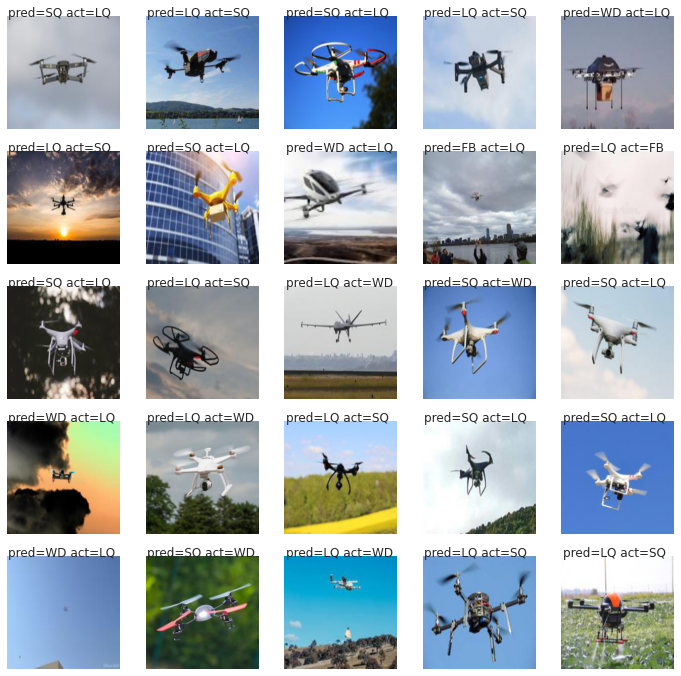

In [24]:
figure=plt.figure(figsize=(12,12))
if len(predicted_class) > 25: 
    for i in range(25):
      plt.subplot(5,5,i+1)
      plt.axis(False)
      plt.imshow(unnormalize(wrong_predict[i].cpu()),interpolation='bilinear')
      prediction = class_names_dict.get(predicted_class[i])
      actual     = class_names_dict.get(actual_class[i])
      s="pred="+str(prediction)+" act="+str(actual)
      plt.text(2,-1,s)
else:
  print('Less than 25 images:', len(predicted_class))

#### Plotting correctly classified images received from last epoch. Will throw error message if misclassified images <25. In case of such an event adjust the subplots to suit the number of images to be plotted

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

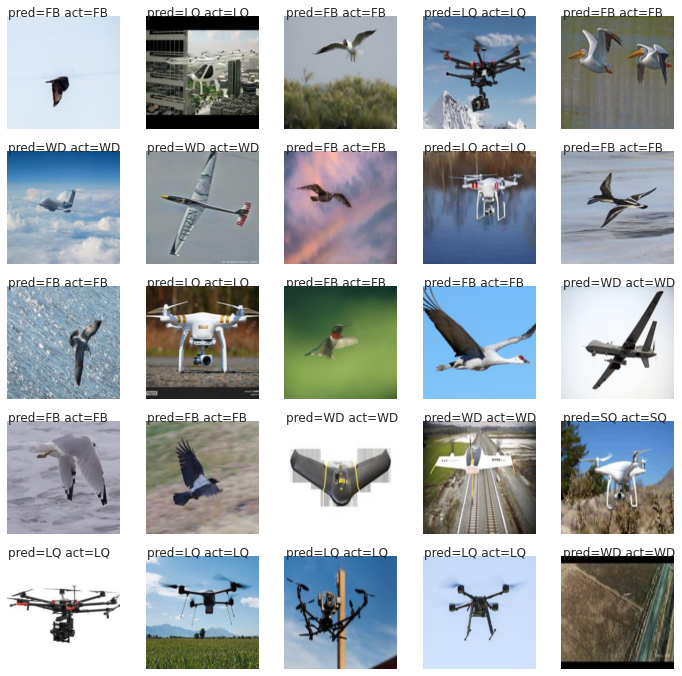

In [25]:
figure=plt.figure(figsize=(12,12))
if len(predicted_class) > 25: 
    for i in range(25):
      plt.subplot(5,5,i+1)
      plt.axis(False)
      plt.imshow(unnormalize(correct_predict[i].cpu()),interpolation='bilinear')
      prediction = class_names_dict.get(correct_pred_class[i])
      actual     = class_names_dict.get(correct_act_class[i])
      s="pred="+str(prediction)+" act="+str(actual)
      plt.text(2,-1,s)
else:
  print('Less than 25 images:', len(predicted_class))

#### Train & Test accuracies, Test Losses & Train Losses

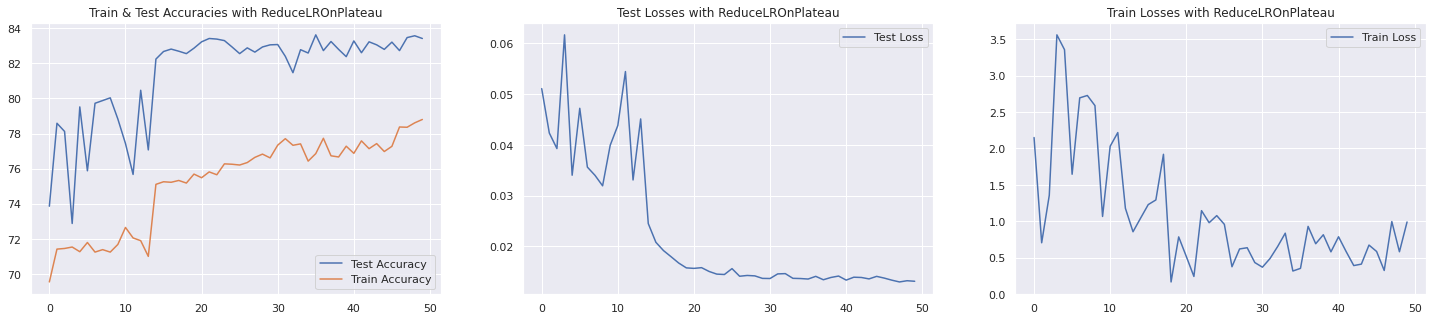

In [26]:
figure = plt.figure(figsize=(25,5))
labels = ['With L1=0.0001 & L2=0.0005']

plt.subplot(1,3,1)
plt.title("Train & Test Accuracies with ReduceLROnPlateau")
plt.plot(test_acc_all,label='Test Accuracy')
plt.plot(train_acc_all,label='Train Accuracy')
plt.legend(loc="best")

plt.subplot(1,3,2)
plt.title("Test Losses with ReduceLROnPlateau")
plt.plot(test_loss_all,label='Test Loss')
plt.legend(loc="best")

plt.subplot(1,3,3)
plt.title("Train Losses with ReduceLROnPlateau")
plt.plot(train_loss_all,label='Train Loss')
plt.legend(loc="best")